In [1]:
import glob
import os
import random

import librosa as rosa
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from collections import Counter
from IPython.display import Audio, display
from tensorflow.python.ops import gen_audio_ops
from tqdm.notebook import tqdm


print(f"Tensorflow v{tf.__version__}")

Tensorflow v2.12.0


In [2]:
DATA_DIR = "data"

KOMPUTER_DIR = os.path.join(DATA_DIR, "komputer")
GOOGLE_DIR = os.path.join(DATA_DIR, "google")
ML_COMMON_DIR = os.path.join(DATA_DIR, "ml_common")
NOISE_DIR = os.path.join(DATA_DIR, "noise")

TARGET_WORD = "komputer"
LABELS = ["komputer", "unknown", "noise"]

SAMPLE_RATE = 16000
FRAME_LENGTH = 320
FRAME_STEP = 160

POOLING_SIZE = [1, 6]

In [21]:
def plot_audio(audio):
    _, axe = plt.subplots(figsize=(8, 6))
    axe.plot(audio)
    axe.set_title("Wykres amplitudy dźwięku w dziedzinie czasu")
    axe.set_xlabel("Czas (s)")
    axe.set_ylabel("Amplituda")
    plt.show()
    display(Audio(audio, rate=16000))


def plot_spectrogram(spec, sample_rate=16000):
    spec = np.squeeze(spec)
    spec = np.rot90(spec, -1)
    _, axe = plt.subplots(figsize=(8, 6))
    im = axe.imshow(spec, aspect="auto", origin="lower", cmap="jet")

    n_freq_bins = spec.shape[0]
    y_ticks = np.linspace(0, n_freq_bins - 1, 5).astype(int)
    y_freqs = (y_ticks / (n_freq_bins - 1)) * (sample_rate / 2)
    axe.set_yticks(y_ticks)
    axe.set_yticklabels(y_freqs.astype(int))

    axe.set_title("Spektrogram")
    axe.set_xlabel("Czas (s)")
    axe.set_ylabel("Częstotliwość (Hz)")

    plt.colorbar(im, ax=axe, label="Amplituda")
    plt.show()

In [22]:
def normalize_audio(audio):
    audio = audio - np.mean(audio)
    audio = audio / np.max(np.abs(audio))
    return audio


def cut_audio_length(audio, length=SAMPLE_RATE):
    audio_len = len(audio)
    if audio_len < length:
        audio = np.append(audio, np.zeros(length - audio_len))
    audio = audio[:length]
    return audio


def cure_audio(audio):
    audio = cut_audio_length(audio)
    audio = normalize_audio(audio)
    return tf.cast(audio, tf.float32)


def get_spectrogram(audio):
    spec = gen_audio_ops.audio_spectrogram(
        tf.expand_dims(audio, -1),
        window_size=FRAME_LENGTH,
        stride=FRAME_STEP,
        magnitude_squared=True,
    )
    spec = tf.expand_dims(spec, -1)
    spec = tf.nn.pool(
        input=spec,
        window_shape=POOLING_SIZE,
        strides=POOLING_SIZE,
        pooling_type="AVG",
        padding="SAME",
    )
    spec = np.squeeze(spec, axis=0)
    spec = np.log10(spec + 1e-6)
    return spec

In [23]:
def process_files(files_path, max_files=None):
    spectrograms = []
    files = glob.glob(f"{files_path}/*.wav")
    random.shuffle(files)
    if max_files:
        files = files[:max_files]

    for file in tqdm(files, desc=f"Generating spectrograms from {files_path}"):
        file_name = file.split("/")[-1]
        for label_idx, label in enumerate(LABELS):
            if file_name.startswith(label):
                audio, _ = rosa.load(file, sr=SAMPLE_RATE, mono=True)
                audio = cure_audio(audio)
                assert len(audio) == SAMPLE_RATE
                spectrograms.append((get_spectrogram(audio), label_idx))

    return spectrograms

In [7]:
komputer_set = process_files(KOMPUTER_DIR)
noise_set = process_files(NOISE_DIR)
google_set = process_files(GOOGLE_DIR)
ml_common_set = process_files(ML_COMMON_DIR, max_files=200000)

Generating spectrograms from data/komputer:   0%|          | 0/51108 [00:00<?, ?it/s]

Generating spectrograms from data/noise:   0%|          | 0/27401 [00:00<?, ?it/s]

Generating spectrograms from data/ml_common:   0%|          | 0/200000 [00:00<?, ?it/s]

In [8]:
# ml_common_x, ml_common_y = zip(*ml_common_set)
# ml_common_x = np.array(ml_common_x)
# ml_common_y = np.array(ml_common_y)

# komputer_x, komputer_y = zip(*komputer_set)
# komputer_x = np.array(komputer_x)
# komputer_y = np.array(komputer_y)

# noise_x, noise_y = zip(*noise_set)
# noise_x = np.array(noise_x)
# noise_y = np.array(noise_y)

# np.savez("ml_common.npz", x=ml_common_x, y=ml_common_y)
# np.savez("komputer.npz", x=komputer_x, y=komputer_y)
# np.savez("noise.npz", x=noise_x, y=noise_y)

In [9]:
spectrograms = []
spectrograms.extend(komputer_set)
spectrograms.extend(noise_set)
spectrograms.extend(google_set)
spectrograms.extend(ml_common_set)

print(f"Total spectrograms: {len(spectrograms)}")

Total spectrograms: 278509


In [10]:
random.shuffle(spectrograms)

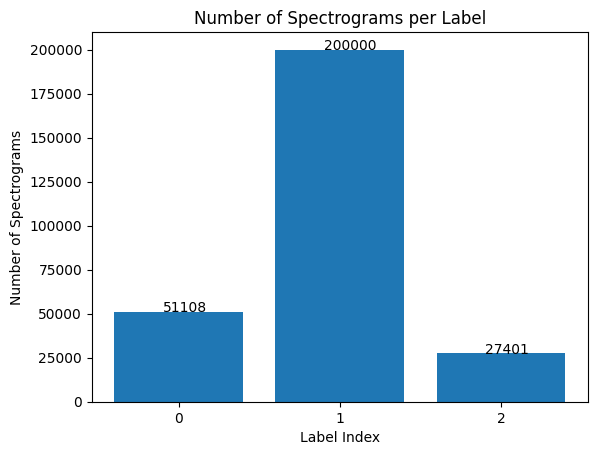

In [11]:
label_indices = [label_idx for _, label_idx in spectrograms]
label_counts = Counter(label_indices)

bars = plt.bar(label_counts.keys(), label_counts.values())

plt.title("Number of Spectrograms per Label")
plt.xlabel("Label Index")
plt.ylabel("Number of Spectrograms")
plt.xticks(list(label_counts.keys()))

for bar, count in zip(bars, label_counts.values()):
    plt.text(
        bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.1, str(count)
    )

plt.show()

In [12]:
specs, labels = zip(*spectrograms)

In [13]:
specs = np.array(specs)
labels = np.array(labels)

In [14]:
no_specs = len(specs)
train_end = int(no_specs * 0.7)
val_end = int(no_specs * 0.85)

ds_x = np.array_split(specs, [train_end, val_end])
ds_y = np.array_split(labels, [train_end, val_end])

In [15]:
np.savez_compressed("train.npz", x=ds_x[0], y=ds_y[0])
np.savez_compressed("val.npz", x=ds_x[1], y=ds_y[1])
np.savez_compressed("test.npz", x=ds_x[2], y=ds_y[2])